# Basic Co-Occurrence Analysis of Human-Cell-Atlas Pancreas Topograhic Maps

Data from Tosti et al, 2021

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn_image as isns
import seaborn as sns
import scipy.signal as signal
from scipy import stats

import statsmodels.stats.multitest as smm

from sonar import sonar, utils
import math
import random

from distinctipy import distinctipy

from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap, LinearSegmentedColormap



In [6]:
import torch

if torch.cuda.is_available():
    import torch as t
    device = 'cuda:0' # put it in a gpu
else:
    import torch as t
    device='cpu'

## Upload sample, define labels

## Pancreas

In [7]:
relevant_cluster_labels =  [
 'Acinar-i',
 'Acinar-s',
 'Acinar-REG+',
 'Activated Stellate',
 'Quiescent Stellate',
 'Alpha',
 'Beta',
 'Gamma (PP)',
 'Delta',
 'Ductal',
 'MUC5B+ Ductal (PDG)',
 'MHC Class II',
 'Schwan'
]

''' Initial annotations are down below. However 'Endothelial' cells are absent at all, 
'B cell' and 'T cell', are zero in all 4 pancreas samples and 
'background' is excluded from the calculations'''

# cluster_labels = ['background',
#  'Acinar-i',
#  'Acinar-s',
#  'Acinar-REG+',
#  'Activated Stellate',
#  'Quiescent Stellate',
#  'Alpha',
#  'Beta',
#  'Gamma (PP)',
#  'Delta',
#  'Ductal',
#  'MUC5B+ Ductal (PDG)',
#  'MHC Class II',
#  'Schwan',
#  'B cell',
#  'T cell',
# 'Endothelial'
# ]


In [8]:
tissue_matrix = np.load('/dh-projects/ag-ishaque/analysis/anastasiia/projects/sonar/test/ISS-pancreas/data/sample_matrices.npz')['sample_'+str(1)]
rescaled = utils.rescale_topographic_tensor(tissue_matrix, scaling_factor=0.3).numpy()

# # Make a list out of pancreas samples to run them all together:
# sample_list = []
# for sample in range(1,5):
#     n_sample = sample

#     tissue_matrix = np.load('/dh-projects/ag-ishaque/analysis/anastasiia/projects/sonar/test/ISS-pancreas/data/sample_matrices.npz')['sample_'+str(n_sample)]
#     # Islet stack
#     rescaled = utils.rescale_topographic_tensor(tissue_matrix, scaling_factor=0.3).numpy()
#     # rescaled_splitted = np.split(rescaled, 16)
#     # islet_stack = np.add.reduce([rescaled_splitted[6],rescaled_splitted[7],rescaled_splitted[8],rescaled_splitted[9]])
#     sample_list.append(rescaled)

# rescaled = sample_list[0] # selecting sample


## Brain

In [ ]:
# osmfish_ref = ['Astrocyte Gfap', 'Astrocyte Mfge8', 'C. Plexus', 'Endothelial', 
#                'Endothelial 1', 'Ependymal', 'Hippocampus', 'Inhibitory CP', 
#                'Inhibitory Cnr1', 'Inhibitory Crhbp', 'Inhibitory IC', 'Inhibitory Kcnip2', 
#                'Inhibitory Pthlh', 'Inhibitory Vip', 'Microglia', 'Oligodendrocyte COP', 
#                'Oligodendrocyte MF', 'Oligodendrocyte Mature', 'Oligodendrocyte NF', 'Oligodendrocyte Precursor cells', 
#                'Pericytes', 'Perivascular Macrophages', 'Pyramidal Cpne5', 'Pyramidal Kcnip2', 
#                'Pyramidal L2-3', 'Pyramidal L2-3 L5', 'Pyramidal L3-4', 'Pyramidal L5', 
#                'Pyramidal L6', 'Vascular Smooth Muscle', 'pyramidal L4']

# relevant_cluster_labels = osmfish_ref

# tissue_matrix_brain_ = np.load('/dh-projects/ag-ishaque/analysis/anastasiia/projects/sonar/test/osmFISH/data/published_cell_matrix.npz')['raw']

In [ ]:
# tissue_matrix_brain = np.delete(tissue_matrix_brain_, [6,32], axis=0) # removing empty entities
# tissue_matrix_brain.shape

# rescaled = tissue_matrix_brain

# Sonar run

In [9]:
def sig(t, k=1):
    return ((1)/(1+(torch.exp(-t*k))))

def smax(t,k=5):
    return (torch.exp(t*k)/(torch.exp(t*k).sum(0)))

rad_ = 500
lin = 1

In [10]:
# For pancreas due to redundant cell types
rescaled = rescaled [1:-2]

In [15]:
son = sonar.Sonar(labels = relevant_cluster_labels, max_radius=rad_,linear_radius_steps=lin, edge_correction=True, circumference_normalization=True)
cooc_template_  = son.co_occurrence_from_tensor(rescaled,interpolate="linear", area_normalization = False) 

# Normalisation

In [16]:
# I couldn't successfully incorporate the function in the sonar package. That is why I left it here
def normalize_co_occurrence(tensor, sonar_obj, original_img): # when sonar will be fixed, the function will need only sonar obj
    """
    Normalize co-occurrence results based on cell type proportions.

    Args:
        tensor (numpy.ndarray): Co-occurrence tensor to normalize.
        sonar_obj (SonarObject): The SonarObject containing metadata.
        original_img (numpy.ndarray): Original image data.

    Returns:
        normalized_coocur (numpy.ndarray): Normalized co-occurrence tensor.
    """
    
    # Normalisation
    n, _, m = tensor.shape
    normalized_coocur = np.zeros_like(tensor)
    
    for i in range(n):
        for j in range(n):
            for k in range(m):
                normalized_coocur[i, j, k] = tensor[i, j, k] / (son.meta['pixel_counts'].values[j]*son.meta['pixel_proportions'].values[i])

    return normalized_coocur

In [17]:
normalized_coocur = normalize_co_occurrence(tensor=cooc_template_, sonar_obj=son, original_img = rescaled)

# Significance test

In [18]:
# It was the work in progress to update this function, that is why I kept it here and not in the separate package file

# Libraries to be used in the package file:
# import numpy as np
# from scipy import stats
# import statsmodels.stats.multitest as smm


def significance_test(normalized_coocur=normalized_coocur, log10p_corrected = True):
    """
    Perform significance tests on normalized co-occurrence data.

    This function conducts significance tests to determine if the normalized co-occurrence values
    are significantly different from the overall mean. It uses t-tests for each cell type pair and distance.

    Args:
        normalized_coocur (numpy.ndarray): 3D array of normalized co-occurrence values.
        metadata: Additional metadata (not used in this function).

    Returns:
        less_greater (tuple of numpy.ndarray): tuple of two elements that contains arrays of corrected p-values which show 
        the significance of correlation values for "less" and "greater" alternatives.

    Note:
        The p-values are corrected for multiple hypothesis testing using the Benjamini-Hochberg procedure (method='fdr_bh').
        This correction helps control the False Discovery Rate (FDR) when conducting numerous tests.
        Corrected p-values are provided in the returned 3D arrays for further interpretation and analysis.
    """
    less_greater = [] # maybe should be changed to numpy.ndarray, but I find a list more convenient in this case

    # performing 1-sided ttest with two alternative options: lees and greater, to see both "ups" and "donws"
    alternatives = ["less", "greater"]
    for one_side in alternatives:

        significance_test = np.zeros((normalized_coocur.shape[0],normalized_coocur.shape[1],normalized_coocur.shape[2]))
        for pivot_cell_type in range(normalized_coocur.shape[0]):
            for target_cell_type in range(normalized_coocur.shape[1]):
                for distance in range(normalized_coocur.shape[2]):

                    value_to_test = normalized_coocur[pivot_cell_type, target_cell_type, distance]
                    t_statistic, p_value = stats.ttest_1samp(normalized_coocur[pivot_cell_type,:,distance], value_to_test, alternative=one_side)
                    significance_test[pivot_cell_type, target_cell_type, distance] = p_value

    # correction for multiple hypothesis testing
        significance_test_flatten = significance_test.flatten()
        corrected_p_values = smm.multipletests(significance_test_flatten, method='fdr_bh')[1] 
        corrected_p_values3D = corrected_p_values.reshape(normalized_coocur.shape[0],normalized_coocur.shape[1],normalized_coocur.shape[2])

        if log10p_corrected:
            corrected_p_values3D = -np.log10(corrected_p_values3D)
        
        less_greater.append(corrected_p_values3D)

    return less_greater[0], less_greater[1]



In [19]:
significant_enri, significant_depl  = significance_test(normalized_coocur=normalized_coocur)

# Plotting

In [20]:
np.log10(0.0095) # the output is ~2. So this is the reason for the thresholding values

-2.0222763947111524

In [ ]:
"""The following function is the large plotting function. Sometimes it took me too much to plot. So I leave 
here the function itself and down below the script of the function will be splitted onto smaller functionall 
parts which you can use if needed
Editional notes: 
* I really think that significance test should be included in the sonar object. Then we can reduce the number of arguments in the function.
    so all arguments like "significant_enri, significant_depl, normalized_coocur"can go away, once they are in sonar
* I was a bit confused on how to make plots flexible. Maybe you should rewrite some functions with the gridspec package so that plots can be 
    flexible to take up to 30  cell types and adjust automatically to the number of cell-types.
"""

# from datetime import datetime
# import random
# from distinctipy import distinctipy
# from matplotlib.backends.backend_pdf import PdfPages
# from matplotlib.colors import ListedColormap, LinearSegmentedColormap
# import seaborn as sns

def plotting_enr_depl_report(significant_enri, significant_depl, normalized_coocur, son, curves_colors = True, report_filename = "pancreas", file_extencion=".pdf", threshold_enr=2, threshold_depl=2, seed_= 13): 
    """generates and saves a spatial correlation plot report.
    Generates a spatial correlation plot report and save is in the selected format, default=PDF.

    Args:
        significant_enri (numpy.ndarray): Matrix of enriched values.
        significant_depl (numpy.ndarray): Matrix of depleted values.
        normalized_coocur (numpy.ndarray): Normalized co-occurrence data.
        son: Sonar object.
        curves_colors (bool, optional): Whether to generate distinct curve colors. Default is True.
        report_filename (str, optional): Base filename for the generated report. Default is "pancreas".
        file_extension (str, optional): File extension for the report file. Default is ".pdf".
        threshold_enr (float, optional): Threshold for enriched values. Default is 2.
        threshold_depl (float, optional): Threshold for depleted values. Default is 2.
        seed_ (int, optional): Seed for random color generation. Default is 13.

    Outputs:
        None

    Generates a PDF report containing spatial correlation plots and heatmaps.
    """
    # The part which is responcible for creating the color maps and color bars, preprocessing the data:

    # defining variables for the enriched and depleted plot:
    signif_type_ = (significant_enri, significant_depl)
    cmap_names_ = ['enr_cmap', 'depl_cmap']
    cmap_threshold_ = (threshold_enr, threshold_depl)
    enr_color = [(0, 0, 0), (1, 0, 0)]
    depl_color = [ (0, 0, 0),(0.4, 0.7, 0.9)]
    cmap_colors_ = (enr_color, depl_color)

    # lists for storage values
    signif_type_result = []
    cmap_result = []
    # colormaps and colorbars for enriched and depleted:
    for signif_type, cmap_names, cmap_threshold, cmap_colors in zip(signif_type_, cmap_names_, cmap_threshold_, cmap_colors_):
        heatmap_modif = signif_type.copy()
        if cmap_threshold:
            heatmap_modif[heatmap_modif<cmap_threshold] = 0
        n_bins = 600  # Number of bins in the colormap. I used this number because the colorbar scale ranges from 0 to 6
        cmap = LinearSegmentedColormap.from_list(cmap_names, cmap_colors, N=n_bins)
        cmap_np = cmap(np.linspace(0, 1, 600))
        black = np.array([0, 0, 0, 1])
        cmap_np[:200, :] = black
        cmap_2black = ListedColormap(cmap_np)

        signif_type_result.append(heatmap_modif)
        cmap_result.append(cmap_2black)

    # Merging significances to create a common heatmap
    enr_val_modif = signif_type_result[0]
    depl_val_modif = signif_type_result[1]
    enr_depl_merged = enr_val_modif - depl_val_modif # Subtracting because results are reversed

    # colormaps and colorbars for merged:
    colors = [(0.4, 0.7, 0.9), (0, 0, 0), (1, 0, 0)]  # Blue, Black, Red
    n_bins = 1200  # Number of bins in the colormap
    cmap_name = 'cmap4merged'
    cmap4merged = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
    cmap4merged_np = cmap4merged(np.linspace(0, 1, 1200))
    black = np.array([0, 0, 0, 1])
    cmap4merged_np[400:800, :] = black
    cmap4merged2black = ListedColormap(cmap4merged_np)



    # The part which is responcible for actual plotting and creating the report:

    # filename
    formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M_%S") # just to make names of the output reports unique
    filename = report_filename + formatted_datetime + file_extencion
    pdf_pages = PdfPages(filename) # "open"the .pdf

    # colors
    if curves_colors:
        random.seed(seed_)
        N = 32# number of colours to generate
        curves_colors = distinctipy.get_colors(N) # generate N visually distinct colours


    for pivot_cell_type in range(normalized_coocur.shape[0]):
        # hidden heatmaps for colorbars
        fig_not_show, (ax_noshow_enri, ax_noshow_depl) = plt.subplots(ncols=2, figsize = (3,2))
        sns.heatmap(enr_val_modif[pivot_cell_type,:,:], cmap=cmap_result[0], ax=ax_noshow_enri, cbar=False, xticklabels=False, yticklabels=False, vmin = 0, vmax=6)
        sns.heatmap(-depl_val_modif[pivot_cell_type,:,:], cmap=cmap_result[1], ax=ax_noshow_depl, cbar=False, xticklabels=False, yticklabels=False, vmin = 0, vmax=6)
        plt.close()

        figwidth = 10 # Maybe should be in the function arguments
        figheight = 10
        fig, (ax_curve, ax_show_comb) = plt.subplots(2,1, figsize = (figwidth,figheight), sharex=True)
        plt.suptitle(f"Spatial correlation plot for {son.meta.index[pivot_cell_type]} cells", fontsize = 18)

        # Adjust the spacing between subplots
        plt.subplots_adjust(hspace=0.07)

        # Generating curves
        for target_cell_type in range(normalized_coocur.shape[0]):
            ax_curve.plot(normalized_coocur[pivot_cell_type,target_cell_type], color=curves_colors[target_cell_type % len(curves_colors)], 
            label=(son.meta.index.to_list()[target_cell_type] + " (" + str(son.meta["pixel_percentage"].to_list()[target_cell_type]) + "%)"))
            ax_curve.legend(loc="upper right", bbox_to_anchor=(1.4, 1), borderaxespad=1.5)
            ax_curve.set_ylim(0,5)
        ax_curve.set_ylabel("Sonar spatial enrichment")
        # ax_curve.annotate("Spatial correlation plot for ... cells", xy=(0.5,(np.max(ax_curve.get_ylim()))), fontsize = 18) # this can be used as a plot title
               
        # # get more flexible custum legend object
        # leg = ax_curve.legend(loc='upper right', bbox_to_anchor=(1.4, 1))
        # # change the line width for the legend
        # for line in leg.get_lines():
        #     line.set_linewidth(4.0)

        # significance heatmap
        sns.heatmap(enr_depl_merged[pivot_cell_type,:,:], cmap=cmap4merged2black, ax=ax_show_comb, cbar=False, yticklabels = son.meta.index.to_list())
        ax_show_comb.set_xlabel('Distance from center (um)', fontsize = 12)
        ax_show_comb.text((normalized_coocur.shape[2]+2*(normalized_coocur.shape[2]/figwidth)),1,"Significance \n (-log10 p-value)", fontsize=12, ha="right", va='top')

        cbar_ax1 = fig.add_axes([9.3/figwidth, 0.12, 0.02, 0.25]) #parameters for colorbars (left, bottom, width, hight)
        cbar_ax1.text(-8.5/figwidth,35/figheight,"Enrichment", fontsize = 10, rotation=90) # current proportions are not optimal. Needs a better way. Maybe a gridspec.
        cbar_ax2 = fig.add_axes([10/figwidth, 0.12, 0.02, 0.25]) 
        cbar_ax2.text(-11.5/figwidth,38/figheight,"Depletion", fontsize = 10, rotation=90) 

        cbar_enr = fig.colorbar(ax_noshow_enri.collections[0], cax=cbar_ax1, location="right", use_gridspec=False, shrink=5, pad = 0.5)
        cbar_depl = fig.colorbar(ax_noshow_depl.collections[0], cax=cbar_ax2, location="right", use_gridspec=False, shrink=5)

        cbar_adapted_ticks = [0,0,2,0,4,0,6]
        cbar_enr.set_ticks(cbar_adapted_ticks)
        cbar_depl.set_ticks(cbar_adapted_ticks)

        # plt.savefig("output.png") # .pdf takes ages to generate, so I switched to .png

        # Save the current figure to the PDF file
        pdf_pages.savefig()

        # Close the current figure
        plt.close()
                
    # Close the PDF file
    pdf_pages.close()

In [21]:
# the first part of the plotting function in the final tool:

threshold_enr=2 
threshold_depl=2

signif_type_ = (significant_enri, significant_depl)
cmap_names_ = ['enr_cmap', 'depl_cmap']
cmap_threshold_ = (threshold_enr, threshold_depl)
enr_color = [(0, 0, 0), (1, 0, 0)]
depl_color = [ (0, 0, 0),(0.4, 0.7, 0.9)]
cmap_colors_ = (enr_color, depl_color)

signif_type_result = []
cmap_result = []

for signif_type, cmap_names, cmap_threshold, cmap_colors in zip(signif_type_, cmap_names_, cmap_threshold_, cmap_colors_):
    heatmap_modif = signif_type.copy()
    if cmap_threshold:
        heatmap_modif[heatmap_modif<cmap_threshold] = 0

    n_bins = 600  # Number of bins in the colormap
    cmap = LinearSegmentedColormap.from_list(cmap_names, cmap_colors, N=n_bins)
    cmap_np = cmap(np.linspace(0, 1, 600))
    black = np.array([0, 0, 0, 1])
    cmap_np[:200, :] = black
    cmap_2black = ListedColormap(cmap_np)

    signif_type_result.append(heatmap_modif)
    cmap_result.append(cmap_2black)

enr_val_modif = signif_type_result[0]
depl_val_modif = signif_type_result[1]

enr_depl_merged = enr_val_modif - depl_val_modif

colors = [(0.4, 0.7, 0.9), (0, 0, 0), (1, 0, 0)]  # Blue, Black, Red
n_bins = 1200  # Number of bins in the colormap
cmap_name = 'cmap4merged'
cmap4merged = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
cmap4merged_np = cmap4merged(np.linspace(0, 1, 1200))
black = np.array([0, 0, 0, 1])
cmap4merged_np[400:800, :] = black
cmap4merged2black = ListedColormap(cmap4merged_np)

In [21]:
# the second part of the plotting function in the final tool:

from datetime import datetime
formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
pdf_filename = "pancreas_1_combined_heatmap"+formatted_datetime + ".pdf"
pdf_pages = PdfPages(pdf_filename)

seed_=13

random.seed(seed_)
N = 32# number of colours to generate
curves_colors = distinctipy.get_colors(N) # generate N visually distinct colours


for pivot_cell_type in range(normalized_coocur.shape[0]):
    # hidden heatmaps for colorbars
    fig_not_show, (ax_noshow_enri, ax_noshow_depl) = plt.subplots(ncols=2, figsize = (3,2))
    sns.heatmap(enr_val_modif[pivot_cell_type,:,:], cmap=cmap_result[0], ax=ax_noshow_enri, cbar=False, xticklabels=False, yticklabels=False, vmin = 0, vmax=6)
    sns.heatmap(-depl_val_modif[pivot_cell_type,:,:], cmap=cmap_result[1], ax=ax_noshow_depl, cbar=False, xticklabels=False, yticklabels=False, vmin = 0, vmax=6)
    plt.close()

    figwidth = 10
    figheight = 10
    fig, (ax_curve, ax_show_comb) = plt.subplots(2,1, figsize = (figwidth,figheight), sharex=True)
    plt.suptitle(f"Spatial correlation plot for {son.meta.index[pivot_cell_type]} cells", fontsize = 18)

    # Adjust the spacing between subplots
    plt.subplots_adjust(hspace=0.07)

    for target_cell_type in range(normalized_coocur.shape[0]):
        # ax_curve = axes[0]
        ax_curve.plot(normalized_coocur[pivot_cell_type,target_cell_type], color=curves_colors[target_cell_type % len(curves_colors)], 
        label=(son.meta.index.to_list()[target_cell_type] + " (" + str(son.meta["pixel_percentage"].to_list()[target_cell_type]) + "%)"))
        ax_curve.legend(loc="upper right", bbox_to_anchor=(1.4, 1), borderaxespad=1.5)
        ax_curve.set_ylim(0,5)
    ax_curve.set_ylabel("Sonar spatial enrichment")
    # ax_curve.annotate("Spatial correlation plot for ... cells", xy=(0.5,(np.max(ax_curve.get_ylim()))), fontsize = 18)

    sns.heatmap(enr_depl_merged[pivot_cell_type,:,:], cmap=cmap4merged2black, ax=ax_show_comb, cbar=False, yticklabels = son.meta.index.to_list())
    ax_show_comb.set_xlabel('Distance from center (um)', fontsize = 12)
    ax_show_comb.text((normalized_coocur.shape[2]+2*(normalized_coocur.shape[2]/figwidth)),1,"Significance \n (-log10 p-value)", fontsize=12, ha="right", va='top')

    cbar_ax1 = fig.add_axes([9.3/figwidth, 0.12, 0.02, 0.25]) #parameters for colorbars (left, bottom, width, hight)
    cbar_ax1.text(-8.5/figwidth,35/figheight,"Enrichment", fontsize = 10, rotation=90) #needed to be transfer to proportions
    cbar_ax2 = fig.add_axes([10/figwidth, 0.12, 0.02, 0.25]) 
    cbar_ax2.text(-11.5/figwidth,38/figheight,"Depletion", fontsize = 10, rotation=90) #needed to be transfer to proportions
    # cbar_ax.axis("off")

    cbar_enr = fig.colorbar(ax_noshow_enri.collections[0], cax=cbar_ax1, location="right", use_gridspec=False, shrink=5, pad = 0.5)
    cbar_depl = fig.colorbar(ax_noshow_depl.collections[0], cax=cbar_ax2, location="right", use_gridspec=False, shrink=5)

    cbar_adapted_ticks = [0,0,2,0,4,0,6]
    cbar_enr.set_ticks(cbar_adapted_ticks)
    cbar_depl.set_ticks(cbar_adapted_ticks)

    # plt.savefig("output.png") #.pdf takes ages to generate, so I switched to .png


    # Save the current figure to the PDF file
    pdf_pages.savefig()

    # Close the current figure
    plt.close()
            
# Close the PDF file
pdf_pages.close()

## Some development and testing. 
Can be used for understanding the larger functions and reproducing the smaller bits. Or can be deleted

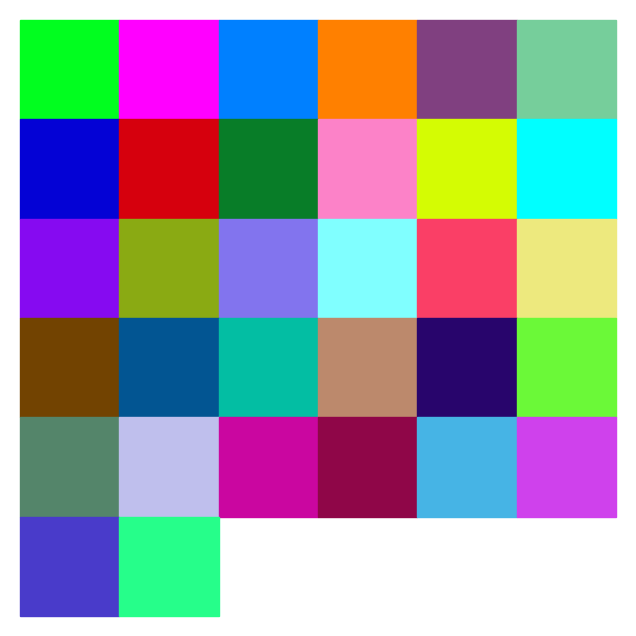

In [13]:
from distinctipy import distinctipy
import random
random.seed(13)

# number of colours to generate
# N = len(indices_above_threshold)
N = 32

# generate N visually distinct colours
curves_colors = distinctipy.get_colors(N)

# display the colours
distinctipy.color_swatch(curves_colors)

In [ ]:
enr_val_modif = significant_enri.copy()
enr_val_modif[enr_val_modif<2] = 0

In [17]:
depl_val_modif = significant_depl.copy()
depl_val_modif[depl_val_modif<2] = 0

In [18]:
enr_depl_merged = enr_val_modif + depl_val_modif

In [29]:
enr_depl_merged = significant_enri-significant_depl

In [21]:
from matplotlib.colors import LinearSegmentedColormap
# Create your custom colormap
colors = [(0.4, 0.7, 0.9), (0, 0, 0), (1, 0, 0)]  # Blue, Black, Red
n_bins = 1200  # Number of bins in the colormap
cmap_name = 'custom_cmap'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

custom_cmap_np = custom_cmap(np.linspace(0, 1, 1200))
black = np.array([0, 0, 0, 1])
custom_cmap_np[400:800, :] = black
custom_cmap_2black = ListedColormap(custom_cmap_np)


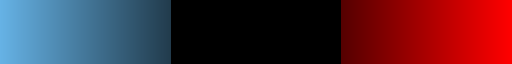

In [22]:
custom_cmap_2black

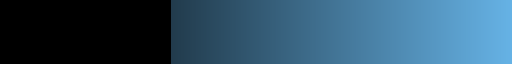

In [23]:
# from matplotlib.colors import ListedColormap, LinearSegmentedColormap

depl_color = [ (0, 0, 0),(0.4, 0.7, 0.9)]
n_bins = 600  # Number of bins in the colormap
depl_cmap_name = 'depl_cmap'
depl_cmap = LinearSegmentedColormap.from_list(depl_cmap_name, depl_color, N=n_bins)

depl_cmap_np = depl_cmap(np.linspace(0, 1, 600))
black = np.array([0, 0, 0, 1])
depl_cmap_np[:200, :] = black
depl_cmap_2black = ListedColormap(depl_cmap_np)

depl_cmap_2black

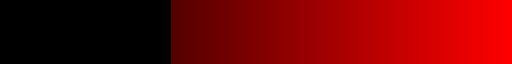

In [24]:
enr_color = [(0, 0, 0), (1, 0, 0)]
n_bins = 600  # Number of bins in the colormap
enr_cmap_name = 'depl_cmap'
enr_cmap = LinearSegmentedColormap.from_list(enr_cmap_name, enr_color, N=n_bins)

enr_cmap_np = enr_cmap(np.linspace(0, 1, 600))
black = np.array([0, 0, 0, 1])
enr_cmap_np[:200, :] = black
enr_cmap_2black = ListedColormap(enr_cmap_np)

enr_cmap_2black

## Brain trial

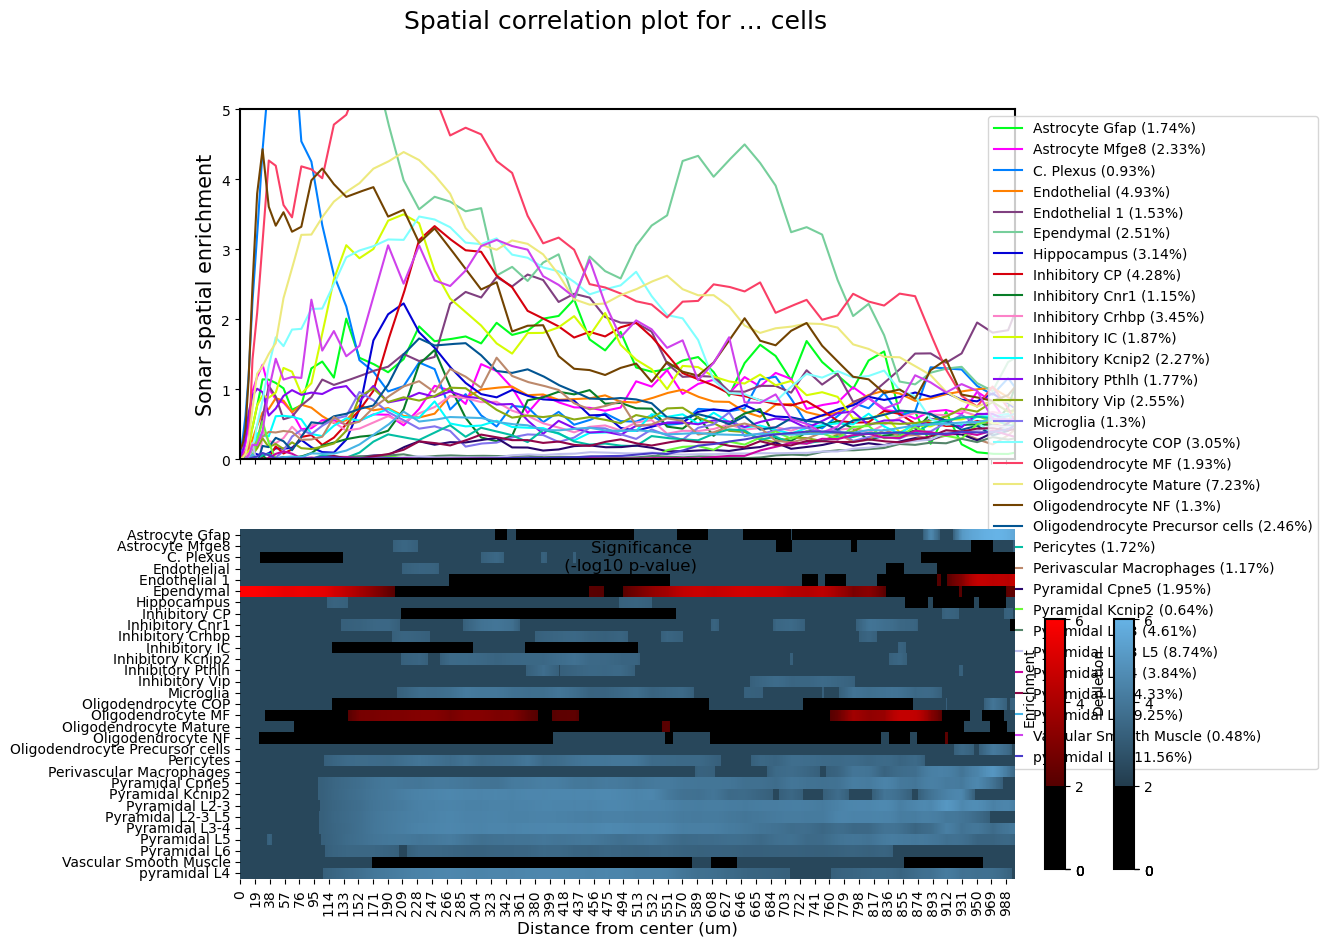

In [153]:
# hidden heatmaps for colorbars
fig_not_show, (ax_noshow_enri, ax_noshow_depl) = plt.subplots(ncols=2, figsize = (10,5))
sns.heatmap(enr_val_modif[5,:,:], cmap=enr_cmap_2black, ax=ax_noshow_enri, cbar=False, xticklabels=False, yticklabels=False, vmin = 0, vmax=6)
sns.heatmap(-depl_val_modif[5,:,:], cmap=depl_cmap_2black, ax=ax_noshow_depl, cbar=False, xticklabels=False, yticklabels=False, vmin = 0, vmax=6)
plt.close()


fig, (ax_curve, ax_show_comb) = plt.subplots(2,1, figsize = (10,10), sharex=True)
plt.suptitle("Spatial correlation plot for ... cells", fontsize = 18)

for target_cell_type in range(normalized_coocur.shape[0]):
    # ax_curve = axes[0]
    ax_curve.plot(normalized_coocur[5,target_cell_type], color=curves_colors[target_cell_type % len(curves_colors)], label=(son.meta.index.to_list()[target_cell_type] + " (" + str(son.meta["pixel_percentage"].to_list()[target_cell_type]) + "%)"))
    ax_curve.legend(loc="upper right", bbox_to_anchor=(1.4, 1))
    ax_curve.set_ylim(0,5)
ax_curve.set_ylabel("Sonar spatial enrichment")


#, width_ratios=[0.99999,0.0000005,0.0000005])
# fig.subplots_adjust(wspace=0.01)
sns.heatmap(enr_depl_merged[5,:,:], cmap=custom_cmap_2black, ax=ax_show_comb, cbar=False, yticklabels = son.meta.index.to_list())
ax_show_comb.set_xlabel('Distance from center (um)', fontsize = 12)
ax_show_comb.text(590,1,"Significance \n (-log10 p-value)", fontsize=12, ha="right", va='top')

cbar_ax1 = fig.add_axes([0.93, 0.12, 0.02, 0.25]) #parameters for colorbars (left, bottom, width, hight)
cbar_ax1.text(-1.1,3.5,"Enrichment", fontsize = 10, rotation=90) #needed to be transfer to proportions
cbar_ax2 = fig.add_axes([0.999, 0.12, 0.02, 0.25]) 
cbar_ax2.text(-1.1,3.8,"Depletion", fontsize = 10, rotation=90) #needed to be transfer to proportions
# cbar_ax.axis("off")

cbar_enr = fig.colorbar(ax_noshow_enri.collections[0], cax=cbar_ax1, location="right", use_gridspec=False, shrink=5, pad = 0.5)
cbar_depl = fig.colorbar(ax_noshow_depl.collections[0], cax=cbar_ax2, location="right", use_gridspec=False, shrink=5)

cbar_adapted_ticks = [0,0,2,0,4,0,6]
cbar_enr.set_ticks(cbar_adapted_ticks)
cbar_depl.set_ticks(cbar_adapted_ticks)

# plt.tight_layout()
 
# plt.show()

# plt.savefig("output.pdf")

# Thresholding by the proportion of cells in the tissue

In [22]:
son.meta

,pixel_counts,pixel_proportions,pixel_percentage
Acinar-i,76427.0,0.088691,8.87
Acinar-s,696597.0,0.808378,80.84
Acinar-REG+,4112.0,0.004772,0.48
Activated Stellate,3774.0,0.004380,0.44
Quiescent Stellate,4405.0,0.005112,0.51
Alpha,2195.0,0.002547,0.25
Beta,7873.0,0.009136,0.91
Gamma (PP),547.0,0.000635,0.06
Delta,249.0,0.000289,0.03
Ductal,56161.0,0.065173,6.52


In [202]:
thresholded_cell_types = list(son.meta.loc[son.meta['pixel_percentage']>0.05].index)
thresholded_cell_types

['Acinar-i',
 'Acinar-s',
 'Acinar-REG+',
 'Activated Stellate',
 'Quiescent Stellate',
 'Alpha',
 'Beta',
 'Gamma (PP)',
 'Ductal',
 'MUC5B+ Ductal (PDG)',
 'MHC Class II']

In [162]:
""" Old peice of code which is not very relevant. 
Accept maybe for the part with cell type thresholding, where I select only those that are abundant enough"""

def plot_significant_enrichments(normalized_coocur=normalized_coocur,
                                    metadata=son.meta,
                                    seed_ = 13,
                                    threshold = 0.0005,
                                    significant_enrichment = significant_enrichment,
                                    filename = "mouse_brain_2",
                                    scaling = 1,
                                    max_dist = 1000):

    metadata["order_of_layers"] = list(range(len(metadata)))
    """ I used the following code to reset indeces of given cell-types, because we needed to remove inapropriate 
    layers from the tensor, not just from the metadata table:"""
        # metadata_reset = metadata.reset_index()
        # metadata_reset.rename(columns={'index': 'cell_type'}, inplace=True)
        # metadata_reset.set_index('order_of_layers', inplace=True)

    all_cell_types = list(metadata.index)
    cell_types_above_threshold = list(son.meta.loc[metadata['pixel_percentage']>0.05, 'order_of_layers']) # to threshold layers of the tensor
    thresholded_cell_types = list(son.meta.loc[metadata['pixel_percentage']>0.05].index) # to threshold metadata table


    # colors
    random.seed(seed_)
    # number of colours to generate
    N = len(cell_types_above_threshold)
    # generate N visually distinct colours
    colors = distinctipy.get_colors(N)


    # filenames
    from datetime import datetime
    current_datetime = datetime.now()
    # Format the date and time
    formatted_datetime = current_datetime.strftime("%Y_%m_%d_%H_%M_%S")
    # Create a PDF file
    pdf_filename = filename + formatted_datetime + ".pdf"
    pdf_pages = PdfPages(pdf_filename)


    for figure in cell_types_above_threshold:

        # Initiating a figure
        # fig, axes = plt.subplots(3,1, figsize=(10,len(cell_types_above_threshold)//2), sharex=True)
        fig = plt.figure(figsize=(14, 12))  # Overall figure size
        from matplotlib import gridspec
        gs = gridspec.GridSpec(3, 1, height_ratios=[1,3,3])

        pivot_cell_type = figure 

        # Sonar cross-correlation curves
        ax_curves = plt.subplot(gs[0])
        for target_cell_type in cell_types_above_threshold:

            ax_curves.plot(normalized_coocur[pivot_cell_type,target_cell_type], label = all_cell_types[target_cell_type], color=colors[target_cell_type % len(colors)])
            ax_curves.legend(loc="upper right", bbox_to_anchor=(-0.2, 1))
            ax_curves.set_ylim(-0.5,5)
        ax_curves.set_ylabel('Relative enrichment', labelpad=15)


        # Define axes for each subplot
        heatmaps = [1, 2]

        # Define alternative types
        alternatives = significant_enrichment
        alt_name = ["less", "greater"]

        for heatmap_loc, alternative, a_name in zip(heatmaps, alternatives, alt_name):
            ax = plt.subplot(gs[heatmap_loc], sharex=ax_curves)
            # Significance heatmap of one-sided t-test
            sns.heatmap(-np.log10(alternative[pivot_cell_type, cell_types_above_threshold, :]), cmap="rocket", yticklabels=thresholded_cell_types, vmin=1.6, vmax=6, ax=ax, cbar=False)
            # Add a text annotation on the right side of the plot

            # ax.annotate(f"alternative={a_name}", xy=(0, 0), xytext=(620, 6), color="black",
            #                 rotation=-90, ha='right', va='center', fontsize=14)
            # Adjust the frame of the heatmap
            for spine in ['top', 'right', 'bottom', 'left']:
                ax.spines[spine].set_visible(True)
                ax.spines[spine].set_linewidth(1)

            
            # Customize x-axis ticks
        xlox = np.linspace(0,max_dist,max_dist//10)
        xtix = [str(int(i)) for i in xlox*scaling] # *3 is getting back from scaling the sample which was used for avoiding memory issues while calculating sonar curves
        plt.xticks(xlox,xtix)   
        # Rotate x-tick labels on the bottom subplot
        ax_curves.set_xticklabels(ax_curves.get_xticklabels(), rotation=90, ha='right')

        plt.tight_layout()

            # Create a color bar
        cbar_ax = fig.add_axes([0.91, 0.05, 0.02, 0.6])  # Adjust the values as needed
        cbar = plt.colorbar(ax.collections[0], cax=cbar_ax)
        cbar.set_label('-Log10 Significance', rotation=90, labelpad=10)
        cbar.outline.set_linewidth(1)

            # Adjust the linewidth of legend lines
        legend_lines = ax_curves.get_legend().get_lines()
        for line in legend_lines:
            line.set_linewidth(5.0)

        plt.xlabel('Distance, um/px', labelpad=40) # Add x-axis label to the entire figure
        plt.suptitle(f"Cross-correlation of {all_cell_types[figure]}", fontsize=15, y=1.01)

            # Save the current figure to the PDF file
        pdf_pages.savefig()

            # Close the current figure
        plt.close()
            
    # # Close the PDF file
    pdf_pages.close()

    # plt.show()

In [163]:
plot_significant_enrichments(normalized_coocur=normalized_coocur,
                                metadata=metadata,
                                seed_ = 13,
                                threshold = 0.05,
                                significant_enrichment = significant_enrichment,
                                filename = "mouse_brain_2",
                                scaling = 1,
                                max_dist = 1000)

/tmp/ipykernel_1188284/2118497482.py:91: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
/tmp/ipykernel_1188284/2118497482.py:91: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
/tmp/ipykernel_1188284/2118497482.py:91: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
/tmp/ipykernel_1188284/2118497482.py:91: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
/tmp/ipykernel_1188284/2118497482.py:91: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
/tmp/ipykernel_1188284/2118497482.py:91: UserWarning: Tight 

## Older workflow

Normality check

In [23]:
cell_types_num = normalized_coocur.shape[0]
distance_num = normalized_coocur.shape[2]

normality_per_distance_unit = np.zeros((cell_types_num, distance_num))

for specific_cell_type in range(normalized_coocur.shape[0]):

    for distance in range(normalized_coocur.shape[2]):
        correlation_per_disrant_unit = normalized_coocur[specific_cell_type,:,distance]

        res = stats.normaltest(correlation_per_disrant_unit)
        dist = stats.chi2(df=2) # null distribution for very large samples is the chi-squared distribution with two degrees of freedom
        norm_res = dist.sf(res.statistic)
        
        normality_per_distance_unit[specific_cell_type, distance] = norm_res

/dh-projects/ag-ishaque/analysis/anastasiia/anaconda3/envs/sonar/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Text(0.5, 1.0, 'Normality of cell-types distribution over distance')

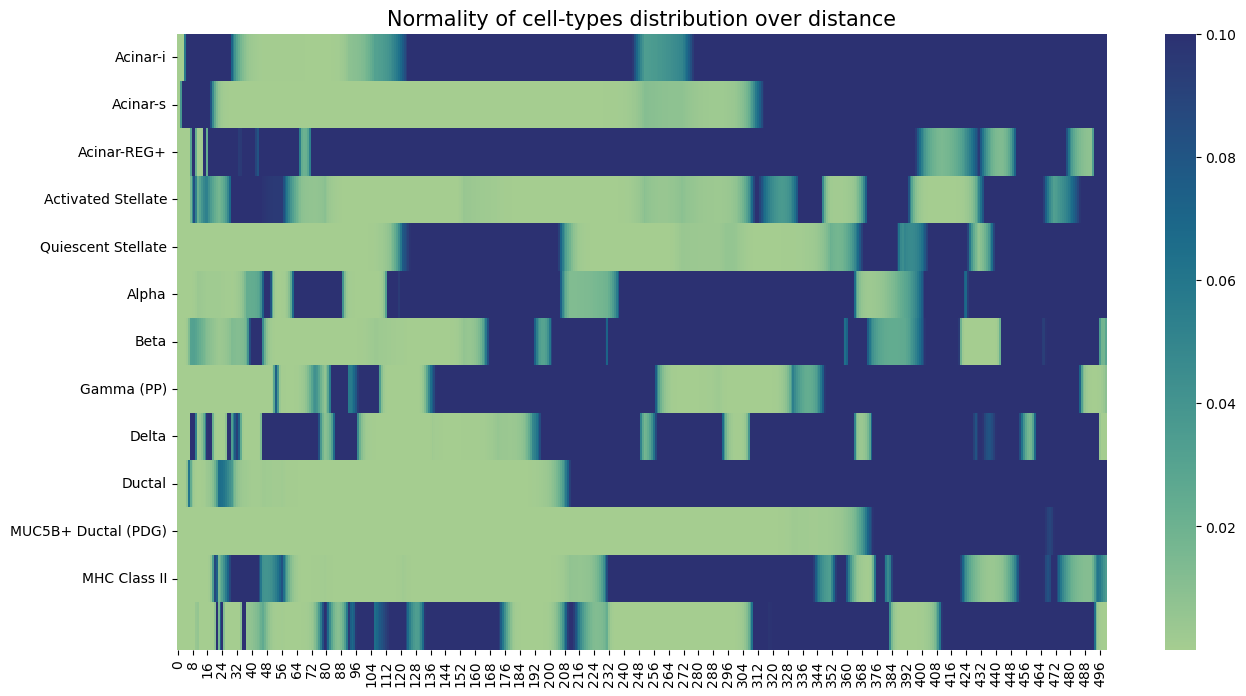

In [24]:
plt.figure(figsize = (15,8))
# plt.subplot(1,2,1)
sns.heatmap(normality_per_distance_unit, cmap="crest", vmax = 0.1, yticklabels = relevant_cluster_labels[:-1])
plt.title("Normality of cell-types distribution over distance")

Text(0.5, 1.0, 'Normality heatmap of Asinar-s cells cross-correlation')

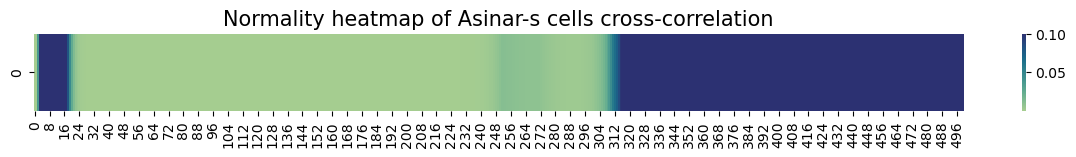

In [25]:
# Single cell type
normality_check2D = normality_per_distance_unit[1,:,np.newaxis]

plt.figure(figsize = (15,1))
# plt.subplot(1,2,1)
sns.heatmap(normality_check2D.T, cmap="crest", vmax = 0.1)
plt.title("Normality heatmap of Asinar-s cells cross-correlation")
# plt.subplot(1,2,2)
# sns.heatmap(input_array.T, cmap="flare", vmax = 0.05)